<a href="https://colab.research.google.com/github/THS-ST/ocr-models/blob/main/OCR_Models_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **OCR Benchmark Notebook**

This serves to **compare multiple OCR libraries** on your own images. It includes:
- A sample run for the following models: Tesseract (via `pytesseract`), EasyOCR, PaddleOCR, DocTR, TrOCR, and RapidOCR
- A simple evaluation using **WER/CER (via `jiwer`)** *(TBA)*
- Runtime timing per image + per model, and a summary chart *(TBA)*

> **Folder layout:**
>
> - `data/images/` → test images (PNG/JPG/TIFF/PDF-as-images)
> - `data/ground_truth.csv` → optional ground-truth file with columns: `filename,text`  
>   (filenames should match exactly the images in `data/images/`)
>

**Acknowledgement**: Thank you to Ang et al. for allowing us to use their synthetic typewritten prescription dataset for our study.


# **Installations**

In [1]:
!git clone https://github.com/THS-ST/ocr-models

fatal: destination path 'ocr-models' already exists and is not an empty directory.


In [2]:

# --- Install Python packages (run once per environment) ---
%pip -q install paddlepaddle
%pip -q install pytesseract easyocr paddleocr doctr[torch] jiwer opencv-python pillow matplotlib rapidfuzz
%pip -q install python-doctr

# Extra (uncomment as needed):
%pip -q install rapidocr onnxruntime
%pip -q install transformers timm accelerate # for TrOCR (Hugging Face)
%pip -q install mmocr==1.0.1 mmengine==0.10.4 mmdet==3.2.0  # complex; only if you want OpenMMLab


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


**Tesseract binary is required** for `pytesseract`.

In [4]:
!apt-get install -y tesseract-ocr

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


# **Initial Imports and Setup**


## System Notes
- GPU is optional but speeds up deep learning models (PaddleOCR, DocTR, Keras-OCR, TrOCR).
- If you see CUDA errors, switch to CPU by installing CPU-only wheels or setting the appropriate flags.


In [7]:

import os, time, json, string, glob, io, math
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Callable, List, Tuple

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

# Evaluation
import jiwer

DATA_DIR = Path("ocr-models/data")
IMAGES_DIR = DATA_DIR / "images"
GT_CSV = DATA_DIR / "ground_truth.csv"

IMAGES_DIR.mkdir(parents=True, exist_ok=True)
print("Expecting images in:", IMAGES_DIR.resolve())
print("Optional ground-truth CSV at:", GT_CSV.resolve())


ImportError: DLL load failed while importing _multiarray_umath: The specified module could not be found.

ImportError: numpy._core.multiarray failed to import

We will load our images with OpenCV (BGR) and return an RGB np.ndarray.

In [5]:
def load_image(path: Path):
    img_bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

The following are additional helper functions for loading images and ground truth values.

In [6]:
def list_images(d: Path) -> List[Path]:
    exts = ["*.png", "*.jpg", "*.JPG", "*.jpeg", "*.tif", "*.tiff", "*.bmp"]
    files = []
    for e in exts:
        files.extend(sorted(d.glob(e)))
    return files

def load_ground_truth(gt_csv: Path) -> pd.DataFrame:
    if gt_csv.exists():
        df = pd.read_csv(gt_csv)
        assert {"filename", "text"}.issubset(df.columns), "ground_truth.csv must have columns: filename,text"
        return df
    else:
        return pd.DataFrame(columns=["filename", "text"])

def get_gt_for(fname: str, gt_df: pd.DataFrame) -> str:
    row = gt_df.loc[gt_df["filename"] == fname]
    return "" if row.empty else str(row.iloc[0]["text"])

NameError: name 'pd' is not defined

Next, we define robust text normalization for fair evaluation.

In [7]:
transform = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.Strip(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemovePunctuation(),
])

def compute_metrics(pred: str, ref: str) -> dict:
    if not ref:
        return {"wer": math.nan, "cer": math.nan}
    wer = jiwer.wer(ref, pred, truth_transform=transform, hypothesis_transform=transform)
    cer = jiwer.cer(ref, pred, truth_transform=transform, hypothesis_transform=transform)
    return {"wer": wer, "cer": cer}


Now we can call the functions to load the images and ground truth values.

In [8]:
images = list_images(IMAGES_DIR)
# No ground truth values for now, uncomment as needed
# gt_df = load_ground_truth(GT_CSV)

In [9]:
images

[PosixPath('ocr-models/data/images/2.jpg'),
 PosixPath('ocr-models/data/images/3.jpg'),
 PosixPath('ocr-models/data/images/4.jpg'),
 PosixPath('ocr-models/data/images/5.jpg'),
 PosixPath('ocr-models/data/images/6.jpg'),
 PosixPath('ocr-models/data/images/7.jpg'),
 PosixPath('ocr-models/data/images/8.jpg'),
 PosixPath('ocr-models/data/images/9.jpg'),
 PosixPath('ocr-models/data/images/1.JPG'),
 PosixPath('ocr-models/data/images/10.JPG')]

We will define the following dataclass for our OCR results.

In [10]:
from dataclasses import dataclass

@dataclass
class OCRResult:
    filename: str
    model: str
    pred_text: str
    secs: float

# **1.0: Tesseract**
One of the most widely used OCR engines globally is Tesseract, developed by Google, it utilizes a long short-term memory (LSTM) based neural network for text recognition and has support for over 100 languages (Smith, 2007). It excels at recognizing printed text from high quality images, but performance significantly drops with degraded images or complex layouts. The model also faces challenges with handwriting recognition and images with significant distortions such as noise or skew (Gupta et al., 2021).

We will use the ``pytesseract`` module.

In [11]:
import pytesseract

Now we will define our tesseractOCR function. This will take an ``np.ndarray`` and return an extracted text string.

In [12]:
def ocr_tesseract(img_rgb: np.ndarray) -> str:
    pil_img = Image.fromarray(img_rgb)
    text = pytesseract.image_to_string(pil_img)
    return text.strip()

The results will be stored in this array.

In [13]:
tesseract_results = []

Next, we will call this function for all the images in the directory.

In [ ]:
current_model = "tesseract"

for img_path in images:
        img = load_image(img_path)
        start = time.time()
        print("Processing: " + str(img_path) + "...")
        try:
            pred = ocr_tesseract(img)
        except Exception as e:
            pred = f"[ERROR] {e}"
        secs = time.time() - start
        tesseract_results.append(OCRResult(filename=img_path.name, model=current_model, pred_text=pred, secs=secs))

Processing: ocr-models/data/images/2.jpg...
Processing: ocr-models/data/images/3.jpg...
Processing: ocr-models/data/images/4.jpg...
Processing: ocr-models/data/images/5.jpg...
Processing: ocr-models/data/images/6.jpg...
Processing: ocr-models/data/images/7.jpg...
Processing: ocr-models/data/images/8.jpg...
Processing: ocr-models/data/images/9.jpg...
Processing: ocr-models/data/images/1.JPG...
Processing: ocr-models/data/images/10.JPG...


Let's turn the array into a dataframe for a better look at our OCR results.

In [15]:
df = pd.DataFrame([r.__dict__ for r in tesseract_results])
df

filename      model                                          pred_text  \
0    2.jpg  tesseract  Fluimucil 600mg #15\nDissoWve 1 tablet in % gl...   
1    3.jpg  tesseract  Fluimucil 600mg #15\nDissolve 1 tablet in % gl...   
2    4.jpg  tesseract  1. DecolgeniNeozep\n#15\nSig: Take 1 tablet 3x...   
3    5.jpg  tesseract  Decolgen/Neozep #15\n1 tablet 3x/day for 5 day...   
4    6.jpg  tesseract  Decolgen/Neozep #15\n1 tablet three times a da...   
5    7.jpg  tesseract  1. Betadine Gargle\na\nSig: Gargle 3x/day\n\n2...   
6    8.jpg  tesseract  Betadine Gargle a\nGargle 3x/day\n\nDiffiam Lo...   
7    9.jpg  tesseract  Betadine Gargle a\nGargle three times a day\n\...   
8    1.JPG  tesseract  1. Fluimucil 600mg\n#15\n\nSig: Dissolve 1 tab...   
9   10.JPG  tesseract  Amoxicillin 500mg cap #21\nSig: take 1 cap 3x ...   

       secs  
0  0.562565  
1  0.484592  
2  0.448512  
3  0.644881  
4  0.904679  
5  0.521845  
6  0.445936  
7  0.468805  
8  1.099418  
9  0.747380

Since newline characters are printed as is in a dataframe, let's try isolating the text for a better visualization.

In [16]:
for r in tesseract_results:
  print("[" + r.filename + "]")
  print(r.pred_text)
  print("\n")

[2.jpg]
Fluimucil 600mg #15
DissoWve 1 tablet in % glass water 1x/day.

Immunosin 500mg #21
axiday


[3.jpg]
Fluimucil 600mg #15
Dissolve 1 tablet in % glass water once a day.

Immunosin 500mg #21
Three times a day


[4.jpg]
1. DecolgeniNeozep
#15
Sig: Take 1 tablet 3x/day for 5 days

2. Loratadine 10mg
#21

Sig: Take 1 tablet at breakfast for 14 days


[5.jpg]
Decolgen/Neozep #15
1 tablet 3x/day for 5 days

Loratadine 10mg #21
1 tablet 1x/day at breakfast for 14 days


[6.jpg]
Decolgen/Neozep #15
1 tablet three times a day for 5 days

Loratadine 10mg #21
1 tablet once a day at breakfast for 14 days


[7.jpg]
1. Betadine Gargle
a
Sig: Gargle 3x/day

2. Difflam lozenges
#15
Sig: Every 4 hours


[8.jpg]
Betadine Gargle a
Gargle 3x/day

Diffiam Lozenges #15
1x/4hours


[9.jpg]
Betadine Gargle a
Gargle three times a day

Difflam lozenges #15
Every 4 hours


[1.JPG]
1. Fluimucil 600mg
#15

Sig: Dissolve 1 tablet in % glass water once a
day for 5 days

2. Immunosin 500mg
#21

Sig: Take 1 tab

# **2.0: EasyOCR**


In [17]:
import easyocr

In [18]:
easyocr_reader = easyocr.Reader(['en'], gpu=True if os.environ.get("USE_CUDA", "0") == "1" else False)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [19]:
def ocr_easyocr(img_rgb: np.ndarray) -> str:
    result = easyocr_reader.readtext(img_rgb, detail=0, paragraph=True)
    return "\n".join([r.strip() for r in result if r.strip()])

In [20]:
easyocr_results = []

In [21]:
current_model = "easyocr"

for img_path in images:
        img = load_image(img_path)
        start = time.time()
        print("Processing: " + str(img_path) + "...")
        try:
            pred = ocr_easyocr(img)
        except Exception as e:
            pred = f"[ERROR] {e}"
        secs = time.time() - start
        easyocr_results.append(OCRResult(filename=img_path.name, model=current_model, pred_text=pred, secs=secs))

Processing: ocr-models/data/images/2.jpg...
Processing: ocr-models/data/images/3.jpg...
Processing: ocr-models/data/images/4.jpg...
Processing: ocr-models/data/images/5.jpg...
Processing: ocr-models/data/images/6.jpg...
Processing: ocr-models/data/images/7.jpg...
Processing: ocr-models/data/images/8.jpg...
Processing: ocr-models/data/images/9.jpg...
Processing: ocr-models/data/images/1.JPG...
Processing: ocr-models/data/images/10.JPG...


In [22]:
eocr_df = pd.DataFrame([r.__dict__ for r in easyocr_results])
eocr_df

filename    model                                          pred_text  \
0    2.jpg  easyocr  Fluimucil 600mg Dissolve tablet in Yz glass wa...   
1    3.jpg  easyocr  Fluimucil 600mg Dissolve tablet in Yz glass wa...   
2    4.jpg  easyocr  Decolgen Neozep #15 Sig: Take tablet 3xlday fo...   
3    5.jpg  easyocr  Decolgen Neozep tablet 3xlday for 5 days\n#15\...   
4    6.jpg  easyocr  Decolgen Neozep tablet three times day for 5 d...   
5    7.jpg  easyocr  Betadine Gargle\nSig: Gargle 3xlday\nDifflam l...   
6    8.jpg  easyocr  Betadine Gargle Gargle 3xlday\nDifflam Lozenge...   
7    9.jpg  easyocr  Betadine Gargle Gargle three times day\nDiffla...   
8    1.JPG  easyocr  Fluimucil 60Omg #15 Sig: Dissolve tablet in Yz...   
9   10.JPG  easyocr  Amoxicillin 500mg cap #21 Sig: take cap 3x a d...   

        secs  
0  13.879369  
1   6.464476  
2   5.471410  
3   6.201034  
4   5.434204  
5   6.206943  
6   5.433548  
7   6.132843  
8   5.567303  
9   6.159697

In [23]:
for r in easyocr_results:
  print("[" + r.filename + "]")
  print(r.pred_text)
  print("\n")

[2.jpg]
Fluimucil 600mg Dissolve tablet in Yz glass water Ixlday:
#15
Immunosin 50Omg 3xlday
#21


[3.jpg]
Fluimucil 600mg Dissolve tablet in Yz glass water once day:
#15
Immunosin 50Omg Three times day
#21


[4.jpg]
Decolgen Neozep #15 Sig: Take tablet 3xlday for 5 days
Loratadine 1Omg #21 Sig: Take tablet at breakfast for 14 days


[5.jpg]
Decolgen Neozep tablet 3xlday for 5 days
#15
Loratadine 1Omg tablet Ixlday at breakfast for 14 days
#21


[6.jpg]
Decolgen Neozep tablet three times day for 5 days
#15
Loratadine 1Omg tablet once day at breakfast for 14 days
#21


[7.jpg]
Betadine Gargle
Sig: Gargle 3xlday
Difflam lozenges #15 Sig: Every 4 hours


[8.jpg]
Betadine Gargle Gargle 3xlday
Difflam Lozenges Ixl4hours
#15


[9.jpg]
Betadine Gargle Gargle three times day
Difflam lozenges Every hours
#15


[1.JPG]
Fluimucil 60Omg #15 Sig: Dissolve tablet in Yz glass water once a day for 5 days
Immunosin 500mg #21 Sig: Take 1 tablet 3xlday for 7 days


[10.JPG]
Amoxicillin 500mg cap #21 Sig:

# **3.0: PaddleOCR**

In [24]:
import paddleocr
from paddleocr import PaddleOCR

In [ ]:
paddle_ocr = PaddleOCR(
    use_doc_orientation_classify=False,
    use_doc_unwarping=False,
    use_textline_orientation=False)

In [26]:
paddle_results = []

In [27]:
current_model = "paddleocr"

for img_path in images:
        img = load_image(img_path)
        start = time.time()
        print("Processing: " + str(img_path) + "...")
        try:
            pred = paddle_ocr.predict(input=img)[0]['rec_texts']
        except Exception as e:
            pred = f"[ERROR] {e}"
        secs = time.time() - start
        paddle_results.append(OCRResult(filename=img_path.name, model=current_model, pred_text=pred, secs=secs))

Processing: ocr-models/data/images/2.jpg...
Processing: ocr-models/data/images/3.jpg...
Processing: ocr-models/data/images/4.jpg...
Processing: ocr-models/data/images/5.jpg...
Processing: ocr-models/data/images/6.jpg...
Processing: ocr-models/data/images/7.jpg...
Processing: ocr-models/data/images/8.jpg...
Processing: ocr-models/data/images/9.jpg...
Processing: ocr-models/data/images/1.JPG...
Processing: ocr-models/data/images/10.JPG...


In [28]:
pdocr_df = pd.DataFrame([r.__dict__ for r in paddle_results])
pdocr_df

filename      model                                          pred_text  \
0    2.jpg  paddleocr  [Fluimucil600mg, #15, Dissolve 1tablet in ½ gl...   
1    3.jpg  paddleocr  [Fluimucil 600mg, #15, Dissolve 1 tablet in ½ ...   
2    4.jpg  paddleocr  [1.Decolgen/Neozep, #15, Sig: Take 1 tablet 3x...   
3    5.jpg  paddleocr  [Decolgen/Neozep, #15, 1 tablet 3x/day for 5 d...   
4    6.jpg  paddleocr  [Decolgen/Neozep, #15, 1 tablet three times a ...   
5    7.jpg  paddleocr  [1. Betadine Gargle, #1, Sig: Gargle 3x/day, 2...   
6    8.jpg  paddleocr  [Betadine Gargle, #1, Gargle 3x/day, Diffl am ...   
7    9.jpg  paddleocr  [Betadine Gargle, #1, Gargle three times a day...   
8    1.JPG  paddleocr  [1. Fluimucil 600mg, #15, Sig: Dissolve 1table...   
9   10.JPG  paddleocr  [Amoxicillin 500mg cap #21, Sig: take 1 cap 3x...   

       secs  
0  6.145733  
1  7.177164  
2  5.978221  
3  6.118415  
4  6.949420  
5  4.888090  
6  4.348413  
7  5.967088  
8  6.106391  
9  5.125316

In [29]:
for r in paddle_results:
  print("[" + r.filename + "]")
  print(r.pred_text)
  print("\n")

[2.jpg]
['Fluimucil600mg', '#15', 'Dissolve 1tablet in ½ glass water 1x/day.', 'Immunosin 500mg', '#21', '3x/day']


[3.jpg]
['Fluimucil 600mg', '#15', 'Dissolve 1 tablet in ½ glass water once a day', 'Immunosin 500mg', '#21', 'Three times a day']


[4.jpg]
['1.Decolgen/Neozep', '#15', 'Sig: Take 1 tablet 3x/day for 5 days', '2.Loratadine 10mg', '#21', 'Sig: Take 1 tablet at breakfast for 14 days']


[5.jpg]
['Decolgen/Neozep', '#15', '1 tablet 3x/day for 5 days', 'Loratadine 10mg', '#21', '1 tablet 1x/day at breakfast for 14 days']


[6.jpg]
['Decolgen/Neozep', '#15', '1 tablet three times a day for 5 days', 'Loratadine 10mg', '#21', '1 tablet once a day at breakfast for 14 days']


[7.jpg]
['1. Betadine Gargle', '#1', 'Sig: Gargle 3x/day', '2. Dffl am lozenges', '#15', 'Sig: Every 4 hours']


[8.jpg]
['Betadine Gargle', '#1', 'Gargle 3x/day', 'Diffl am Lozenges', '#15', '1x/4hours']


[9.jpg]
['Betadine Gargle', '#1', 'Gargle three times a day', 'Diff am lozenges', '#15', 'Every 4 ho

# **4.0: DocTR**

In [30]:
import doctr
from doctr.models import ocr_predictor
from doctr.io import DocumentFile
from PIL import Image
import pathlib

In [ ]:
doctr_predictor = ocr_predictor(pretrained=True)

In [32]:
def ocr_doctr(img_path: str) -> str:
    # DocTR expects a file or batch; we pass a single image
    doc = DocumentFile.from_images(img_path)
    res = doctr_predictor(doc)
    # extract text blocks in reading order
    lines = []
    for page in res.pages:
        for block in page.blocks:
            for line in block.lines:
                line_text = " ".join([w.value for w in line.words])
                if line_text.strip():
                    lines.append(line_text)
    return "\n".join(lines)

In [33]:
doctr_results = []

In [34]:
current_model = "doctr"

for img_path in images:
        start = time.time()
        print("Processing: " + str(img_path) + "...")
        try:
            pred = ocr_doctr(str(img_path))
        except Exception as e:
            pred = f"[ERROR] {e}"
        secs = time.time() - start
        doctr_results.append(OCRResult(filename=img_path.name, model=current_model, pred_text=pred, secs=secs))

Processing: ocr-models/data/images/2.jpg...
Processing: ocr-models/data/images/3.jpg...
Processing: ocr-models/data/images/4.jpg...
Processing: ocr-models/data/images/5.jpg...
Processing: ocr-models/data/images/6.jpg...
Processing: ocr-models/data/images/7.jpg...
Processing: ocr-models/data/images/8.jpg...
Processing: ocr-models/data/images/9.jpg...
Processing: ocr-models/data/images/1.JPG...
Processing: ocr-models/data/images/10.JPG...


In [35]:
doctr_df = pd.DataFrame([r.__dict__ for r in doctr_results])
doctr_df

filename  model                                          pred_text      secs
0    2.jpg  doctr  Fluimucil 600mg\n#15\nDissolve 1 tablet in % g...  4.548463
1    3.jpg  doctr  Fluimucil 600mg\n#15\nDissolve 1 tablet in % g...  4.767579
2    4.jpg  doctr  1. Decolgen/Neozep\n#15\nSig: Take 1 tablet 3x...  4.593043
3    5.jpg  doctr  Decolgen/Neozep\n#15\n1 tablet 3x/day for 5 da...  5.126666
4    6.jpg  doctr  Decolgen/Neozep\n#15\n1 tablet three times a d...  4.554415
5    7.jpg  doctr  1. Betadine Gargle\n#1\nSig: Gargle 3x/day\n2....  4.054800
6    8.jpg  doctr  Betadine Gargle\n#1\nGargle 3x/day\nDifflam Lo...  4.649288
7    9.jpg  doctr  Betadine Gargle\n#1\nGargle three times a day\...  4.081219
8    1.JPG  doctr  1. Fluimucil 600mg\n#15\nSig: Dissolve 1 table...  5.562180
9   10.JPG  doctr  Amoxicillin 500mg cap #21\nSig: take 1 cap 3x ...  4.279595

In [36]:
for r in doctr_results:
  print("[" + r.filename + "]")
  print(r.pred_text)
  print("\n")

[2.jpg]
Fluimucil 600mg
#15
Dissolve 1 tablet in % glass water 1X/day.
Immunosin 500mg
#21
3x/day


[3.jpg]
Fluimucil 600mg
#15
Dissolve 1 tablet in % glass water once: a day.
Immunosin 500mg
#21
Three times a day


[4.jpg]
1. Decolgen/Neozep
#15
Sig: Take 1 tablet 3x/day for 5 days
2. Loratadine 10mg
#21
Sig: Take 1 tablet at breakfast for 14 days


[5.jpg]
Decolgen/Neozep
#15
1 tablet 3x/day for 5 days
Loratadine 10mg
#21
1 tablet 1x/day at breakfast for 14 days


[6.jpg]
Decolgen/Neozep
#15
1 tablet three times a day for 5 days
Loratadine 10mg
#21
1 tablet once a day at breaktast for 14 days


[7.jpg]
1. Betadine Gargle
#1
Sig: Gargle 3x/day
2. Difflam lozenges
#15
Sig: Every 4 hours


[8.jpg]
Betadine Gargle
#1
Gargle 3x/day
Difflam Lozenges
#15
1x/4hours


[9.jpg]
Betadine Gargle
#1
Gargle three times a day
Difflam lozenges
#15
Every 4 hours


[1.JPG]
1. Fluimucil 600mg
#15
Sig: Dissolve 1 tablet in % glass water once a
day for 5 days
2. Immunosin 500mg
#21
Sig: Take 1 tablet 3x/d

# **5.0: TrOCR**

In [37]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [ ]:
trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

In [39]:
def ocr_trocr(img_rgb: np.ndarray) -> str:
    pixel_values = trocr_processor(images=Image.fromarray(img_rgb), return_tensors="pt").pixel_values
    outputs = trocr_model.generate(pixel_values)
    return trocr_processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()

In [40]:
trocr_results = []

In [41]:
current_model = "trocr"

for img_path in images:
        img = load_image(img_path)
        start = time.time()
        print("Processing: " + str(img_path) + "...")
        try:
            pred = ocr_trocr(img)
        except Exception as e:
            pred = f"[ERROR] {e}"
        secs = time.time() - start
        trocr_results.append(OCRResult(filename=img_path.name, model=current_model, pred_text=pred, secs=secs))

Processing: ocr-models/data/images/2.jpg...
Processing: ocr-models/data/images/3.jpg...
Processing: ocr-models/data/images/4.jpg...
Processing: ocr-models/data/images/5.jpg...
Processing: ocr-models/data/images/6.jpg...
Processing: ocr-models/data/images/7.jpg...
Processing: ocr-models/data/images/8.jpg...
Processing: ocr-models/data/images/9.jpg...
Processing: ocr-models/data/images/1.JPG...
Processing: ocr-models/data/images/10.JPG...


In [42]:
trocr_df = pd.DataFrame([r.__dict__ for r in trocr_results])
trocr_df

filename  model         pred_text      secs
0    2.jpg  trocr        CASHIERIER  3.649664
1    3.jpg  trocr               ***  3.180451
2    4.jpg  trocr           CASHIER  3.196276
3    5.jpg  trocr  ................  2.232864
4    6.jpg  trocr                 :  2.210696
5    7.jpg  trocr               ***  2.640449
6    8.jpg  trocr                 :  2.725280
7    9.jpg  trocr                 :  2.279192
8    1.JPG  trocr             THANK  2.677895
9   10.JPG  trocr  ................  2.255501

Notice that the OCR results are extremely inaccurate, this is because TrOCR processes **one line of text at a time**. Because we fed the model the entire image, the results deviate.

Let's try cropping an image and see the results when fed to the model.

In [43]:
crop_dir = IMAGES_DIR / "1.JPG"
test_img = Image.open(crop_dir).convert("RGB")
test_img = test_img.crop((0, 310, 220, 330))
test_img

In [44]:
test_img_np = np.array(test_img)
trocr_cropped_text = ocr_trocr(test_img_np)

print("TrOCR result on cropped image:")
print(trocr_cropped_text)

TrOCR result on cropped image:
1. FLUIMUCIL 600MG


Now the results are accurate to the image.

A possible solution that can allow feeding the model full text images is to create a function that would first split the images into rows of single line text images and perform TrOCR on each split but this would likely be heavy on load and cause long processing times.

# **6.0: RapidOCR**

In [45]:
from rapidocr import RapidOCR

In [46]:
ocr_rapid = RapidOCR()

[INFO] 2025-10-29 05:49:28,945 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-10-29 05:49:29,169 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-10-29 05:49:29,170 [RapidOCR] main.py:53: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-10-29 05:49:29,301 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-10-29 05:49:29,312 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2025-10-29 05:49:29,312 [RapidOCR] main.py:53: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2025-10-29 05:49:29,349 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-10-29 05:49:29,408 [RapidOCR] download_file.py:60: File exists and is valid: /usr/loc

In [47]:
rapid_results = []

In [48]:
current_model = "rapid"

for img_path in images:
        start = time.time()
        print("Processing: " + str(img_path) + "...")
        try:
            pred = ocr_rapid(str(img_path)).txts
        except Exception as e:
            pred = f"[ERROR] {e}"
        secs = time.time() - start
        rapid_results.append(OCRResult(filename=img_path.name, model=current_model, pred_text=pred, secs=secs))

Processing: ocr-models/data/images/2.jpg...


[INFO] 2025-10-29 05:49:30,686 [RapidOCR] download_file.py:68: Initiating download: https://www.modelscope.cn/models/RapidAI/RapidOCR/resolve/v3.4.0/resources/fonts/FZYTK.TTF
[INFO] 2025-10-29 05:49:32,243 [RapidOCR] download_file.py:82: Download size: 3.09MB
[INFO] 2025-10-29 05:49:32,467 [RapidOCR] download_file.py:95: Successfully saved to: /usr/local/lib/python3.12/dist-packages/rapidocr/models/FZYTK.TTF


Processing: ocr-models/data/images/3.jpg...
Processing: ocr-models/data/images/4.jpg...
Processing: ocr-models/data/images/5.jpg...
Processing: ocr-models/data/images/6.jpg...
Processing: ocr-models/data/images/7.jpg...
Processing: ocr-models/data/images/8.jpg...
Processing: ocr-models/data/images/9.jpg...
Processing: ocr-models/data/images/1.JPG...
Processing: ocr-models/data/images/10.JPG...


In [49]:
rapid_df = pd.DataFrame([r.__dict__ for r in rapid_results])
rapid_df

filename  model                                          pred_text      secs
0    2.jpg  rapid  (Fluimucil600mg, #15, Dissolve1tabletin%glassw...  3.029897
1    3.jpg  rapid  (Fluimucil600mg, #15, Dissolve1tabletin%glassw...  1.280514
2    4.jpg  rapid  (1.Decolgen/Neozep, #15, Sig:Take1tablet3x/day...  1.590374
3    5.jpg  rapid  (Decolgen/Neozep, #15, 1tablet3x/dayfor5days, ...  1.655469
4    6.jpg  rapid  (Decolgen/Neozep, #15, 1tabletthreetimesadayfo...  1.389088
5    7.jpg  rapid  (1.BetadineGargle, #1, Sig:Gargle3x/day, 2.Dif...  0.821181
6    8.jpg  rapid  (Betadine Gargle, #1, Gargle3x/day, Difflam Lo...  0.800413
7    9.jpg  rapid  (BetadineGargle, #1, Garglethreetimesaday, Dif...  0.877016
8    1.JPG  rapid  (1.Fluimucil600mg, #15, Sig:Dissolve1tablet in...  1.154508
9   10.JPG  rapid  (Amoxicillin500mgcap#21, Sig:take 1cap3xadayx1...  0.704019

In [50]:
for r in rapid_results:
  print("[" + r.filename + "]")
  print(r.pred_text)
  print("\n")

[2.jpg]
('Fluimucil600mg', '#15', 'Dissolve1tabletin%glasswater1x/day.', 'Immunosin500mg', '#21', '3x/day')


[3.jpg]
('Fluimucil600mg', '#15', 'Dissolve1tabletin%glasswateronceaday.', 'Immunosin500mg', '#21', 'Threetimesaday')


[4.jpg]
('1.Decolgen/Neozep', '#15', 'Sig:Take1tablet3x/dayfor5days', '2.Loratadine10mg', '#21', 'Sig:Take1tablet atbreakfastfor14days')


[5.jpg]
('Decolgen/Neozep', '#15', '1tablet3x/dayfor5days', 'Loratadine10mg', '#21', '1tablet1x/dayatbreakfastfor14days')


[6.jpg]
('Decolgen/Neozep', '#15', '1tabletthreetimesadayfor5days', 'Loratadine10mg', '#21', '1tabletonceadayatbreakfastfor14days')


[7.jpg]
('1.BetadineGargle', '#1', 'Sig:Gargle3x/day', '2.Difflam lozenges', '#15', 'Sig:Every4hours')


[8.jpg]
('Betadine Gargle', '#1', 'Gargle3x/day', 'Difflam Lozenges', '#15', '1x/4hours')


[9.jpg]
('BetadineGargle', '#1', 'Garglethreetimesaday', 'Difflam lozenges', '#15', 'Every4hours')


[1.JPG]
('1.Fluimucil600mg', '#15', 'Sig:Dissolve1tablet in% glasswater onc

# **Preprocessing for Actual Samples**


Note: for actual sample preprocessing, the selected images were cropped to the desired text area first beforehand

In [51]:
ACTUAL_DIR = Path("actual_samples")
actuals_imgs = list_images(ACTUAL_DIR)

In [52]:
actuals_imgs

[PosixPath('actual_samples/2881.jpg'),
 PosixPath('actual_samples/2883.jpg'),
 PosixPath('actual_samples/2884.jpg'),
 PosixPath('actual_samples/2885.jpg'),
 PosixPath('actual_samples/2886.jpg'),
 PosixPath('actual_samples/2887.jpg'),
 PosixPath('actual_samples/2890.jpg'),
 PosixPath('actual_samples/2882.jpeg'),
 PosixPath('actual_samples/2888.jpeg'),
 PosixPath('actual_samples/2889.jpeg')]

*Helper to display images

In [53]:
def display_image(img, title='Image', cmap=None):
    plt.figure(figsize=(10, 8))
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [54]:
def display_plots(normalized_images, is_gray=1):
  # Get the total number of images
  num_images = len(normalized_images)

  # Decide on the grid layout (e.g., 4 columns)
  cols = 4
  # Calculate the number of rows needed
  rows = math.ceil(num_images / cols)

  # Create a figure and a set of subplots
  # Adjust figsize to make it larger or smaller
  fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))

  # Flatten the axes array to make it easy to loop over
  # (This handles cases where you have only 1 row or 1 col)
  axes = axes.flatten()

  # Loop through your processed images and display them
  for i, img in enumerate(normalized_images):
      if (is_gray):
        axes[i].imshow(img, cmap='gray')
      else:
        axes[i].imshow(img)
      axes[i].set_title(f"Image {i}") # Optional: add a title

  # Hide any unused subplots
  for j in range(num_images, len(axes)):
      axes[j].axis('off')

  # Adjust layout to prevent titles/images from overlapping
  plt.tight_layout()
  plt.show()

## Size Normalization

In [69]:
normalized_images = []

In [70]:
for filepath in actuals_imgs:
  img = cv2.imread(filepath)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  h, w, c = img.shape

  if w > 1000:

      new_w = 1000
      ar = w/h
      new_h = int(new_w/ar)

      img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)

  normalized_images.append(img)

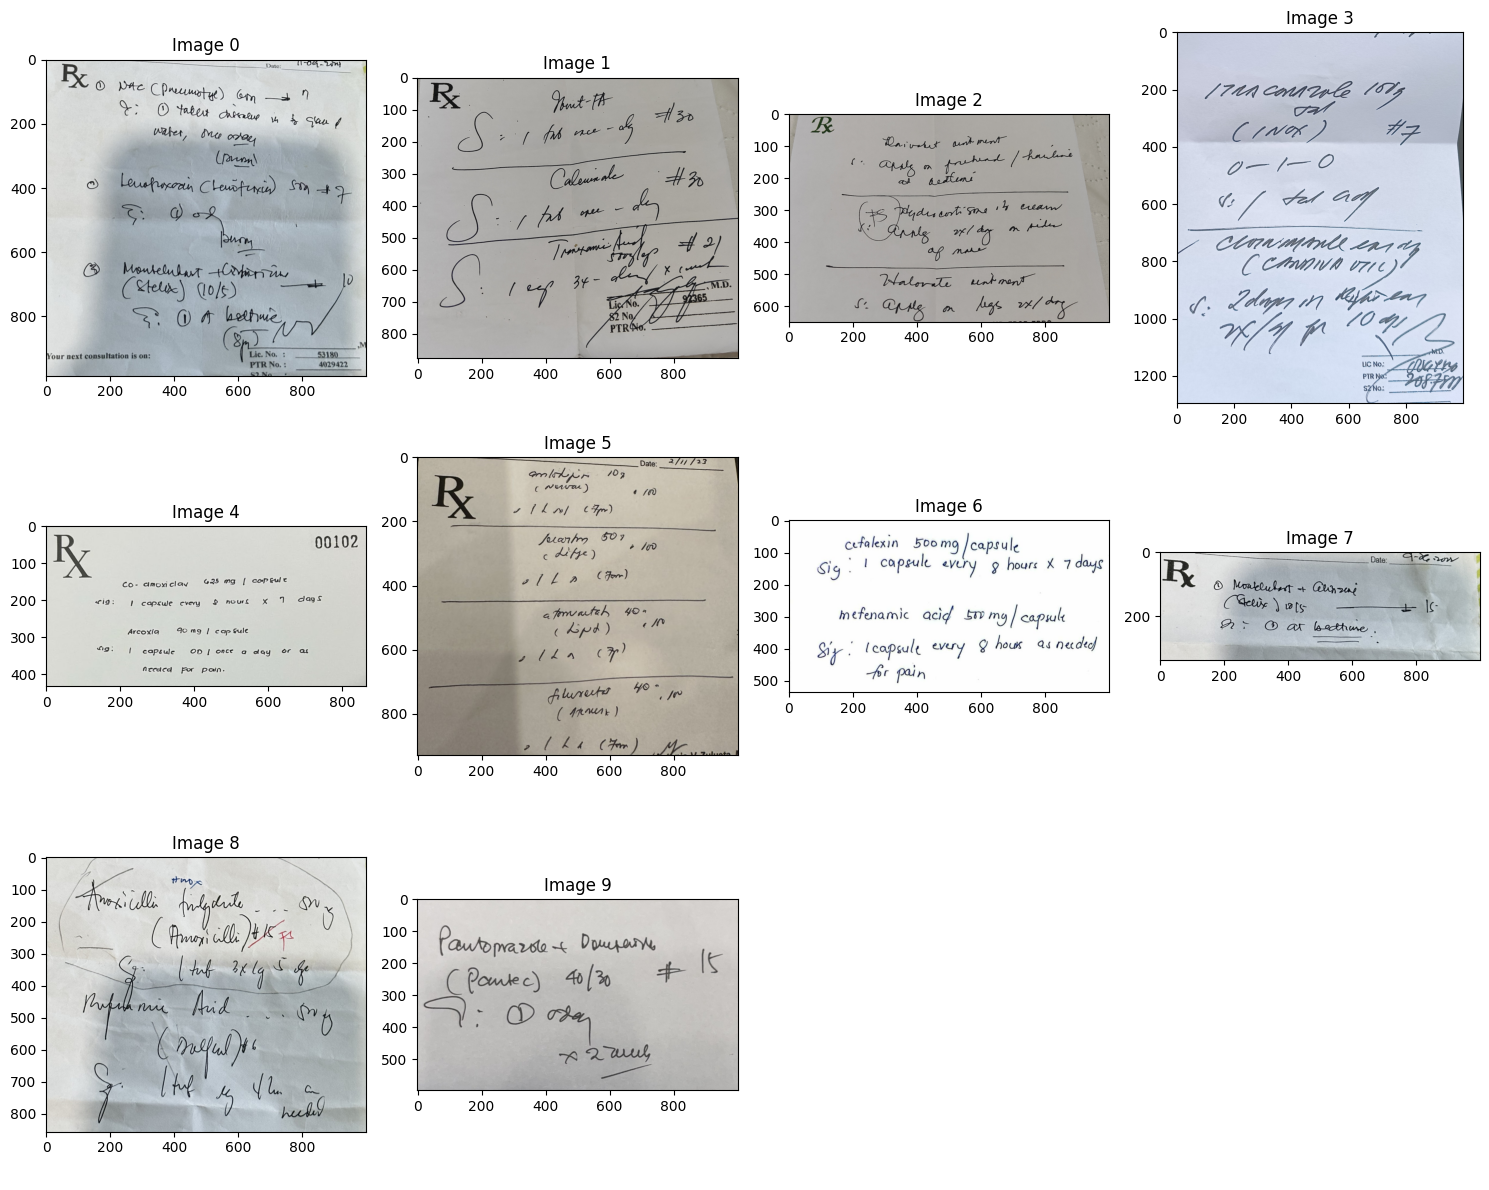

In [71]:
display_plots(normalized_images)

## Grayscaling and Binarization

In [78]:
def thresholding(image, is_otsu=0):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY_INV)
    if (is_otsu):
      ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
      print(f"Otsu's threshold: {ret}")
    return thresh

binarized_imgs = []

for img in normalized_images:
  binarized = thresholding(img,1)
  binarized_imgs.append(binarized)

Otsu's threshold: 126.0
Otsu's threshold: 103.0
Otsu's threshold: 101.0
Otsu's threshold: 159.0
Otsu's threshold: 139.0
Otsu's threshold: 143.0
Otsu's threshold: 163.0
Otsu's threshold: 119.0
Otsu's threshold: 125.0
Otsu's threshold: 139.0


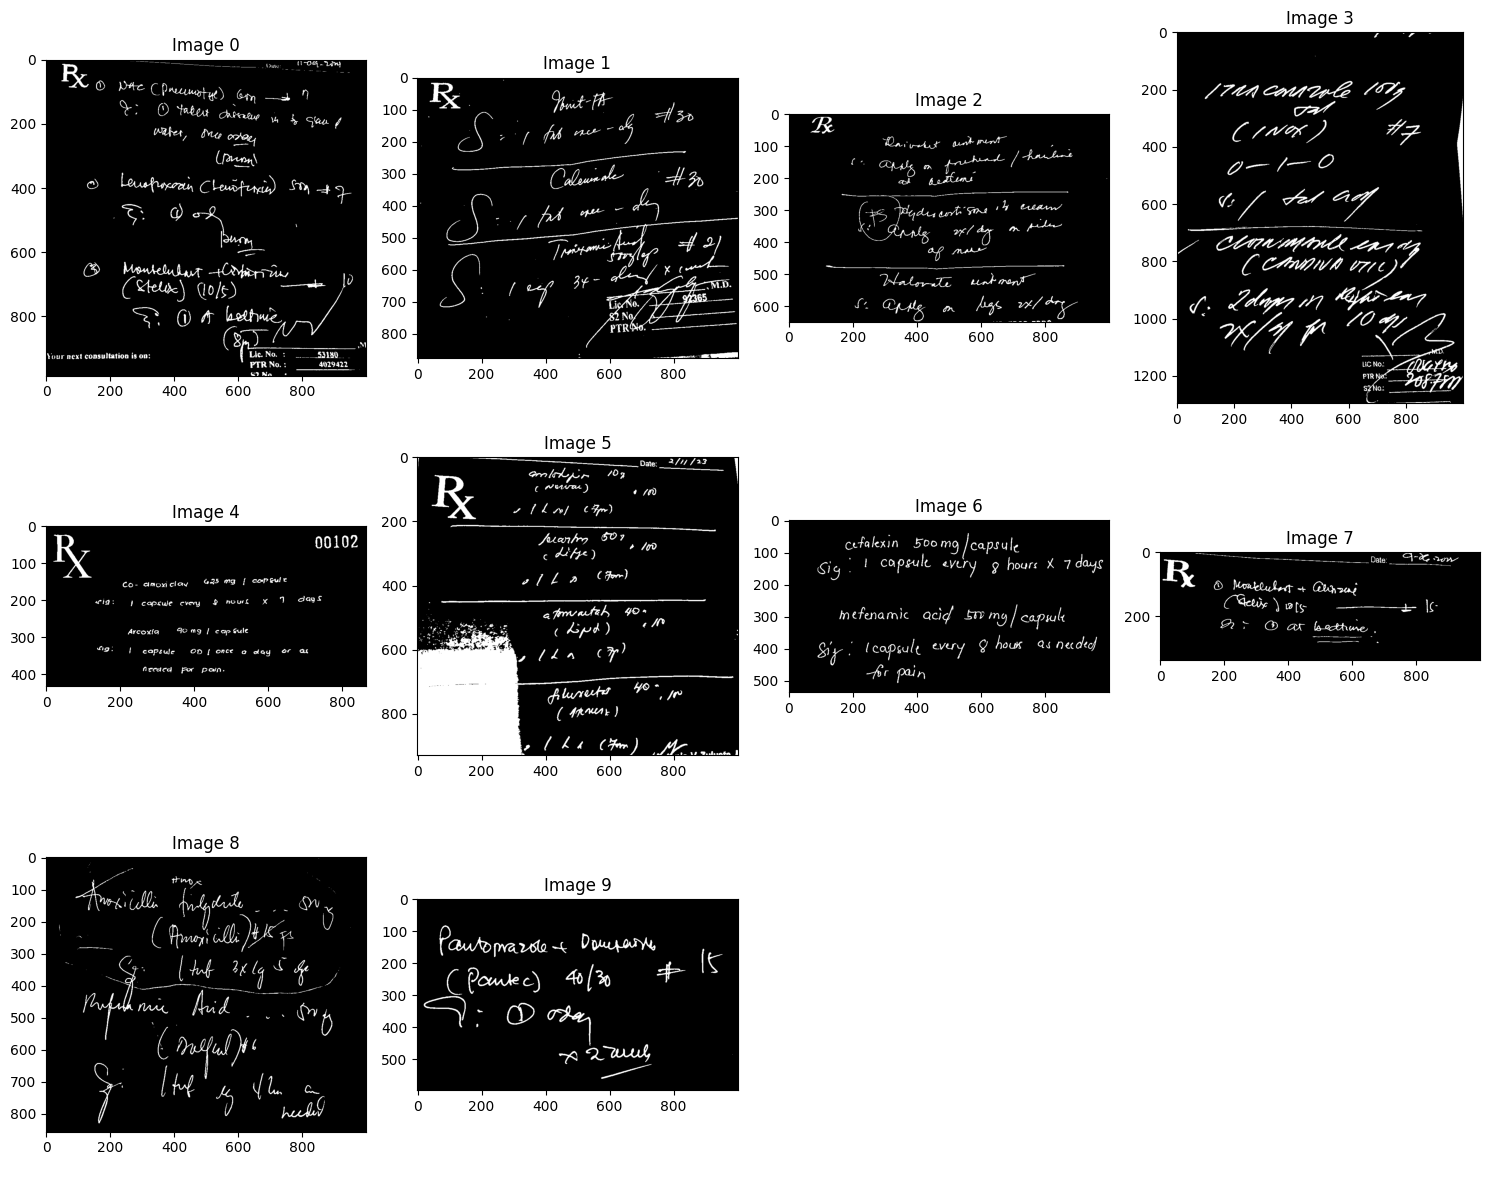

In [79]:
display_plots(binarized_imgs)

## Deskewing

In [80]:
# diff test
corrected_imgs = []

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
from scipy.ndimage import interpolation as inter

for bin_img in binarized_imgs:
  def find_score(arr, angle):
      data = inter.rotate(arr, angle, reshape=False, order=0)
      hist = np.sum(data, axis=1)
      score = np.sum((hist[1:] - hist[:-1]) ** 2)
      return hist, score

  delta = 1
  limit = 5
  angles = np.arange(-limit, limit+delta, delta)
  scores = []
  for angle in angles:
      hist, score = find_score(bin_img, angle)
      scores.append(score)

  best_score = max(scores)
  best_angle = angles[scores.index(best_score)]
  print('Best angle: {}'.format(best_angle))

  # correct skew
  data = inter.rotate(bin_img, best_angle, reshape=False, order=0)
  result = im.fromarray((255 * data).astype("uint8")).convert("RGB")
  corrected_imgs.append(result)

/tmp/ipython-input-3281483512.py:11: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = inter.rotate(arr, angle, reshape=False, order=0)


Best angle: 0


/tmp/ipython-input-3281483512.py:29: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = inter.rotate(bin_img, best_angle, reshape=False, order=0)


Best angle: -4
Best angle: 0
Best angle: -2
Best angle: 0
Best angle: 3
Best angle: 0
Best angle: 2
Best angle: -1
Best angle: 1


# Line Segmentation (Bounding Boxes)

## Pixel Distribution and Vertical Histogram Analysis

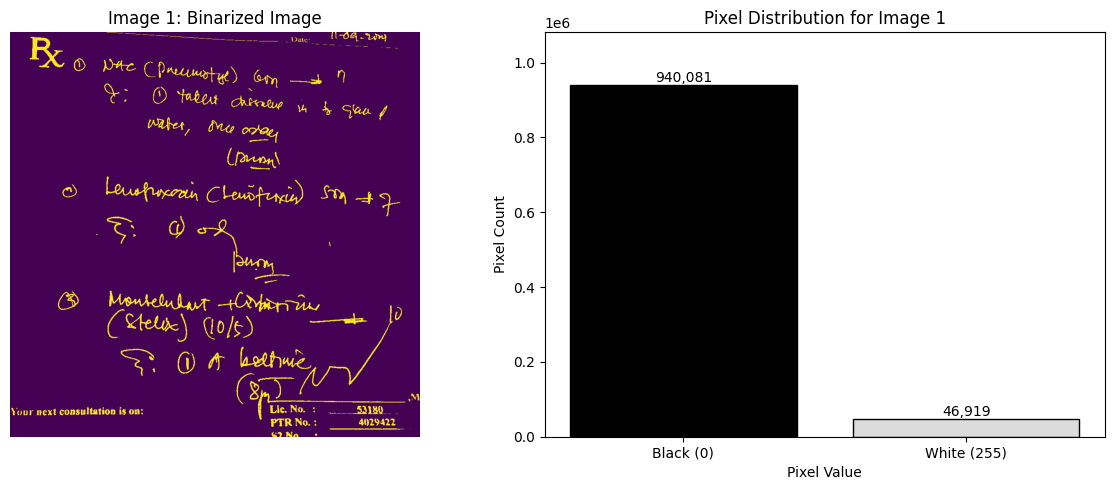

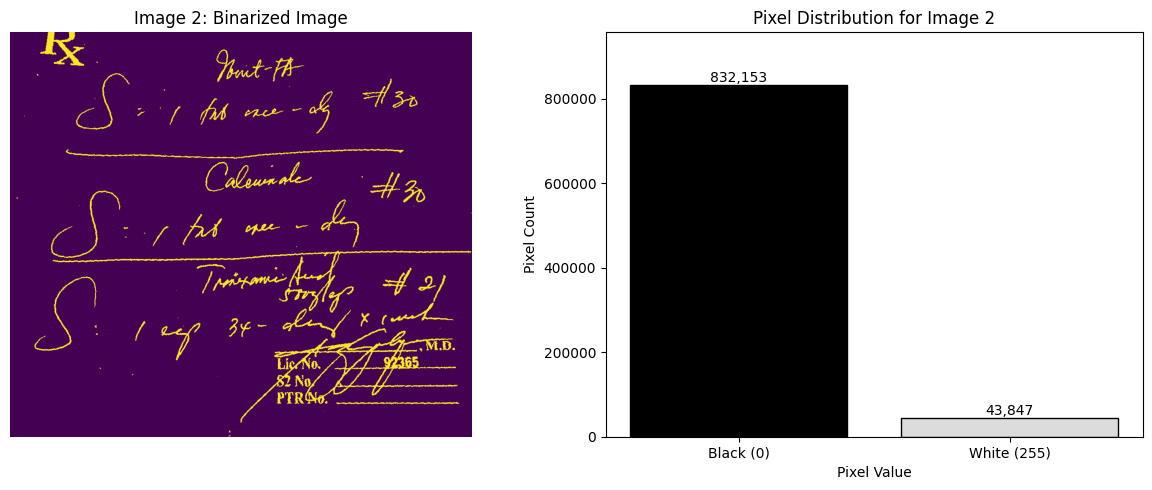

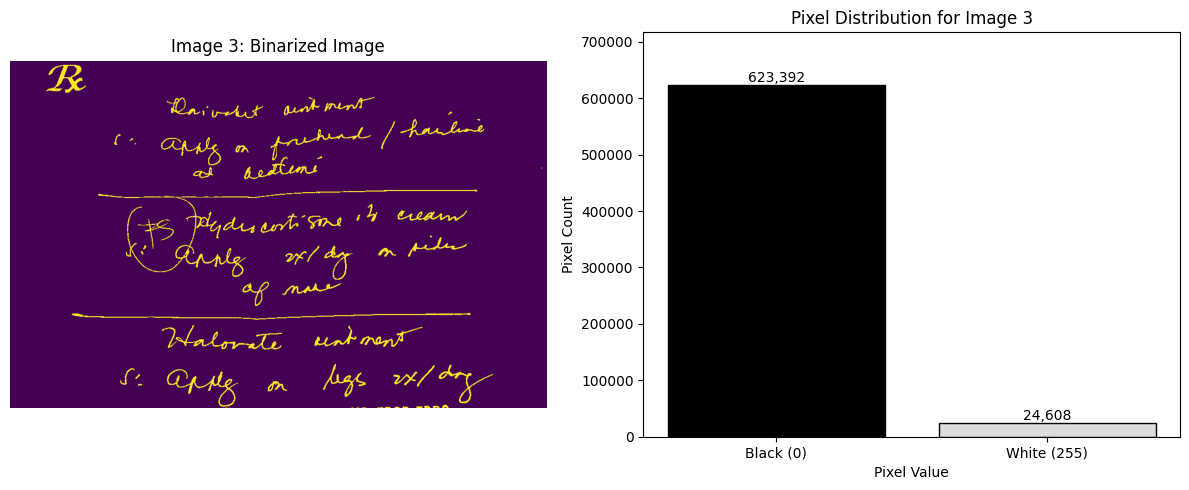

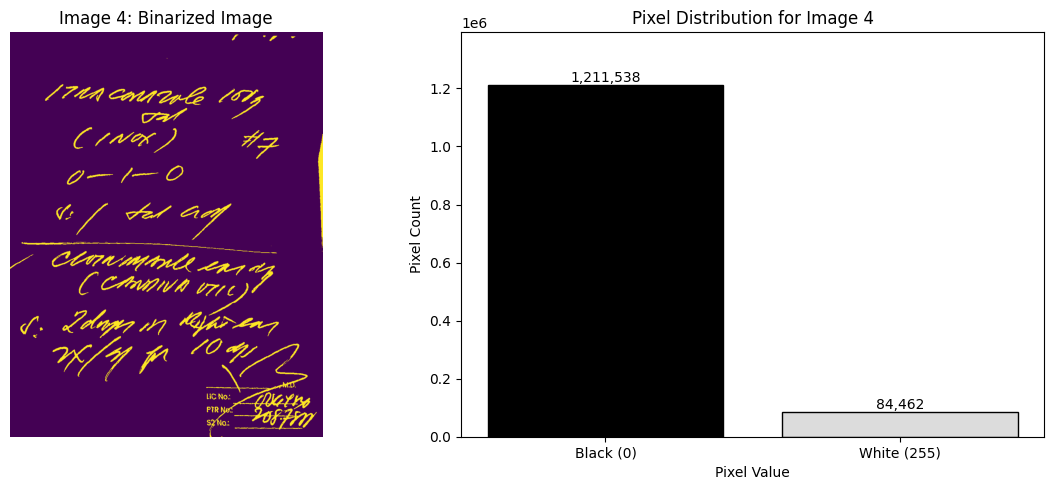

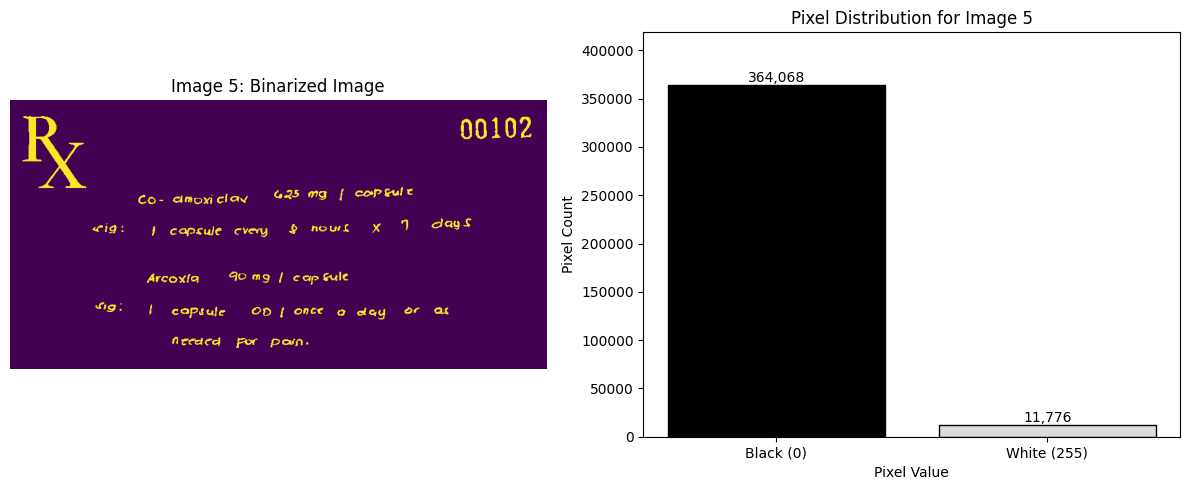

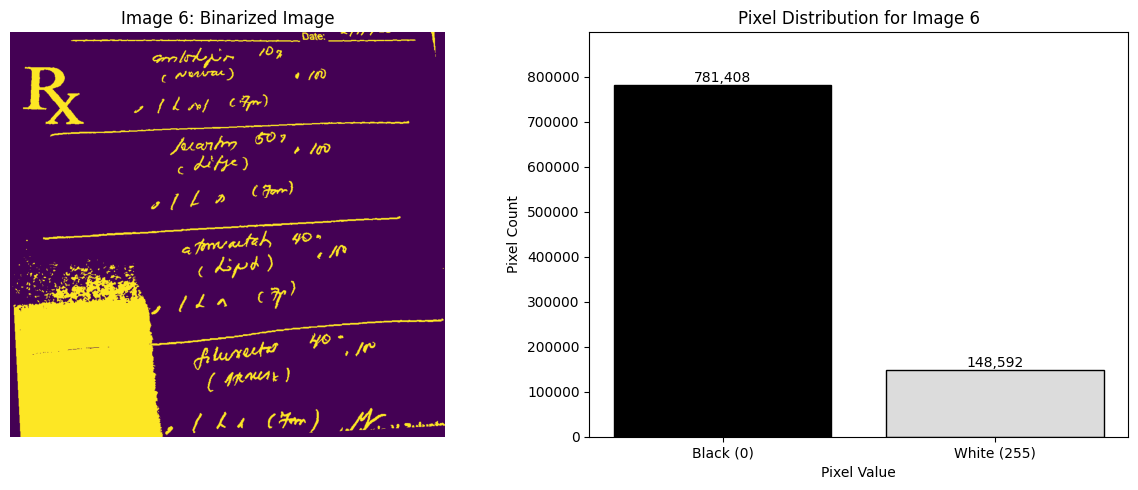

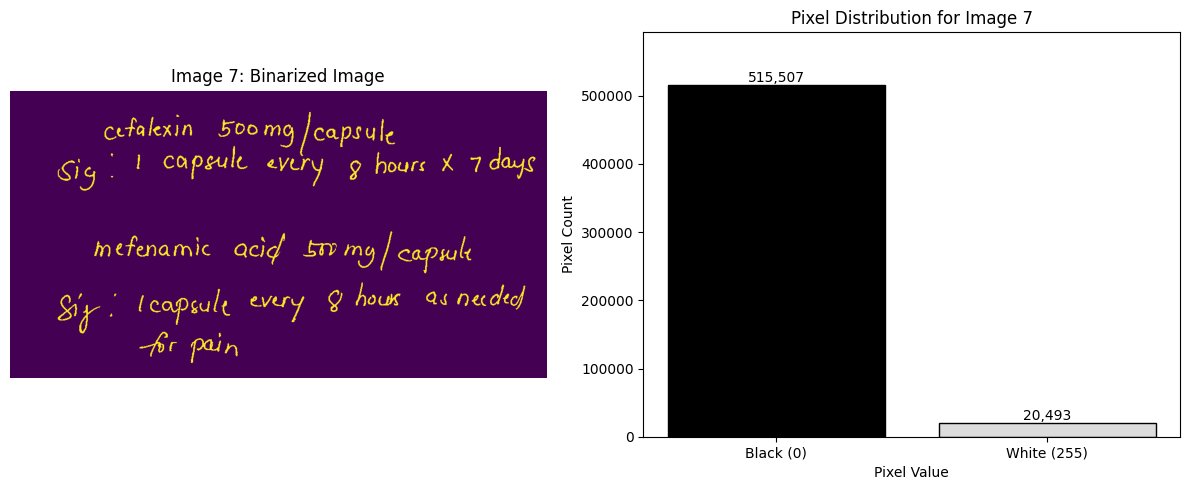

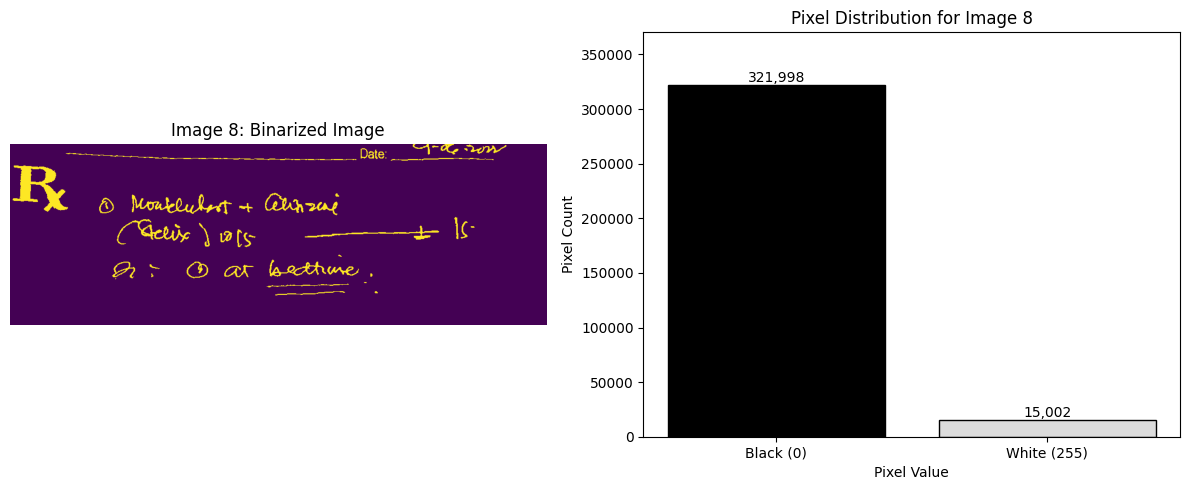

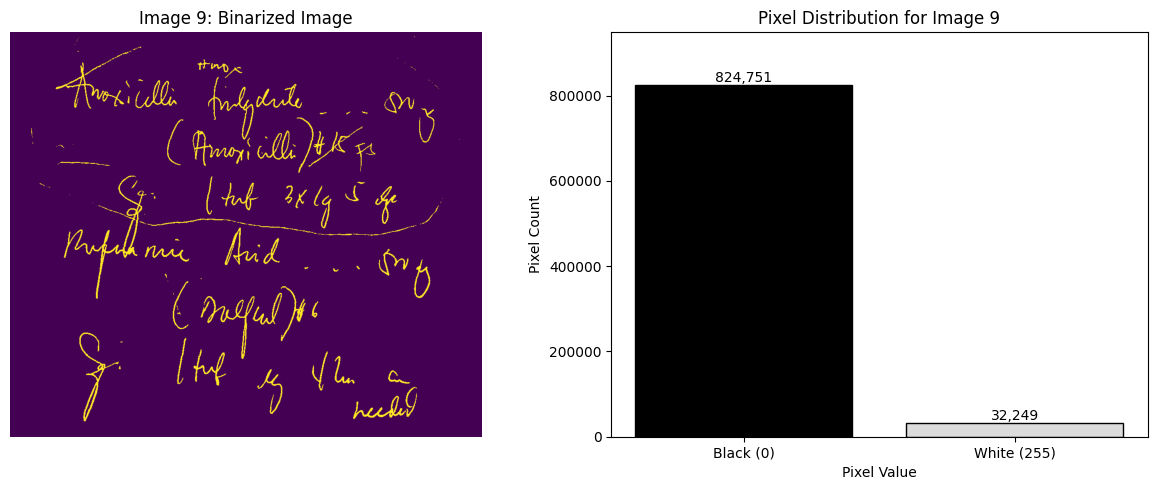

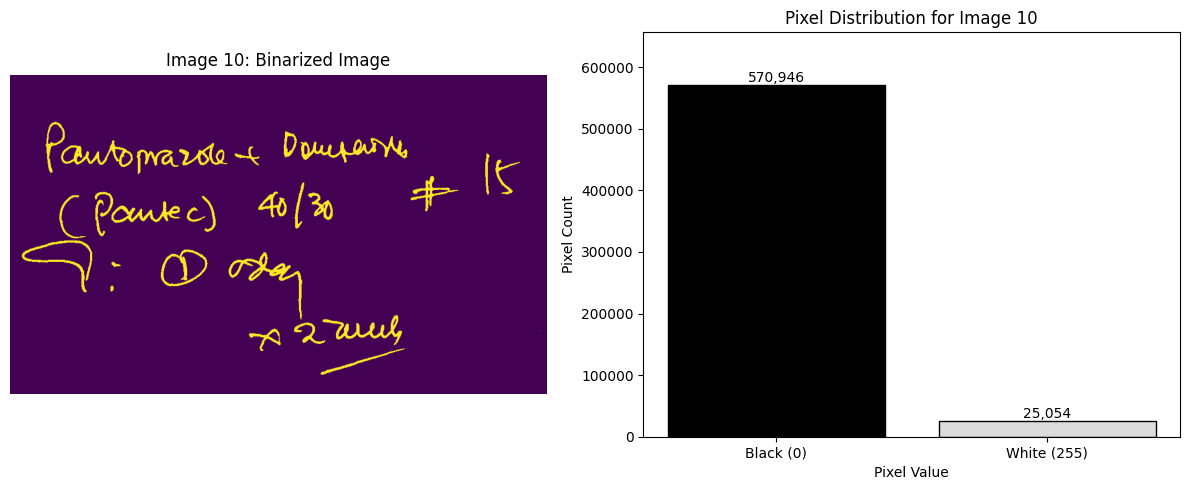

In [81]:
for i, img_pil in enumerate(corrected_imgs):

    # --- 1. Prepare Image ---
    # Convert PIL image to 1-channel ('L') NumPy array
    img_np = np.array(img_pil.convert('L'))

    # --- 2. Create Figure ---
    plt.figure(figsize=(12, 5))

    # --- 3. Plot the Image ---
    # Subplot 1: The Image
    plt.subplot(1, 2, 1) # (1 row, 2 columns, 1st plot)
    plt.imshow(img_np)
    plt.title(f'Image {i+1}: Binarized Image')
    plt.axis('off')

    # --- 4. Plot the Black and White Distribution (Bar Chart) ---
    # Subplot 2: The Bar Chart
    plt.subplot(1, 2, 2) # (1 row, 2 columns, 2nd plot)

    # Flatten the 2D image array to 1D
    pixels = img_np.ravel()

    # Count the number of black (0) and white (255) pixels
    black_count = np.sum(pixels == 0)
    white_count = np.sum(pixels == 1)

    # Check for any other "gray" pixels (not 0 or 255)
    total_pixels = pixels.size
    other_count = total_pixels - black_count - white_count

    # Prepare data for the bar chart
    labels = ['Black (0)', 'White (255)']
    counts = [black_count, white_count]
    # Use 'gainsboro' for the white bar so it's visible on the chart
    colors = ['black', 'gainsboro']

    # If there are "other" pixels, add them to the chart
    if other_count > 0:
        labels.append('Other (1-254)')
        counts.append(other_count)
        colors.append('red') # Make "other" pixels red to stand out
        print(f"Image {i+1} has {other_count} non-binary pixels!")

    # Create the bar chart
    bars = plt.bar(labels, counts, color=colors, edgecolor='black')

    # Add text labels on top of each bar
    plt.bar_label(bars, fmt='{:,.0f}')

    plt.title(f'Pixel Distribution for Image {i+1}')
    plt.ylabel('Pixel Count')
    plt.xlabel('Pixel Value')

    # Set y-axis to be slightly taller than the max count
    if counts: # Check if counts list is not empty
        plt.ylim(0, max(counts) * 1.15)

    # --- 5. Show the plots ---
    plt.tight_layout() # Prevents titles/labels from overlapping
    plt.show()

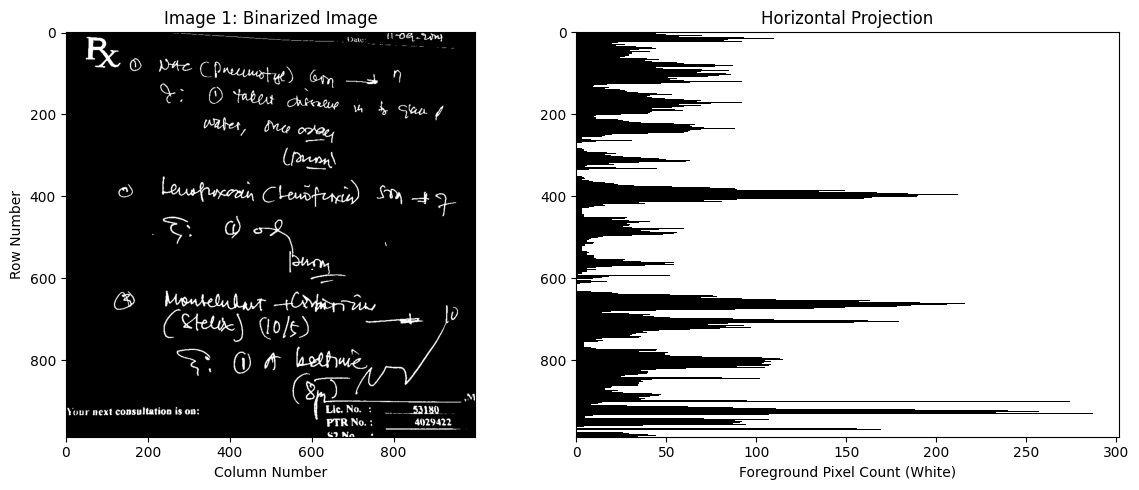

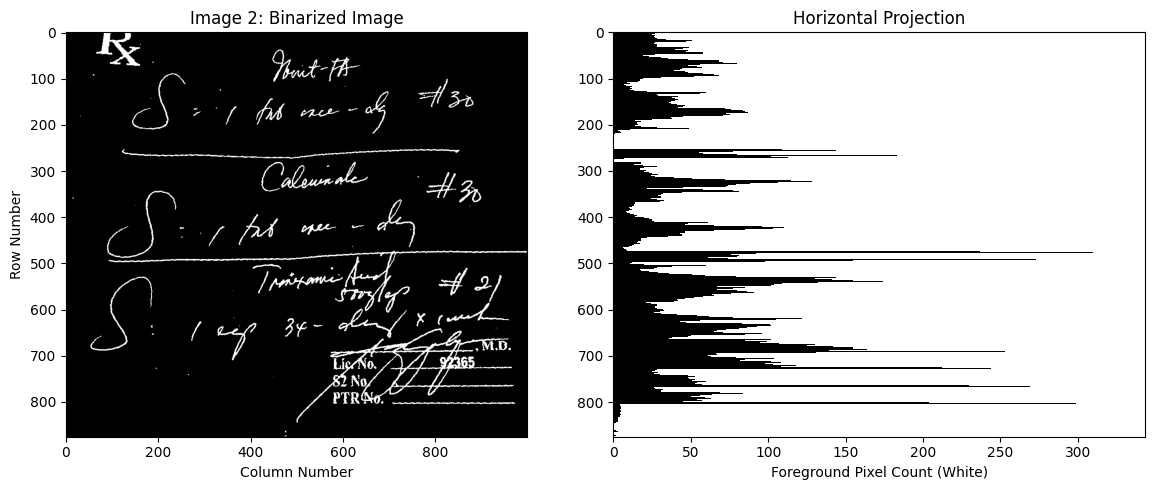

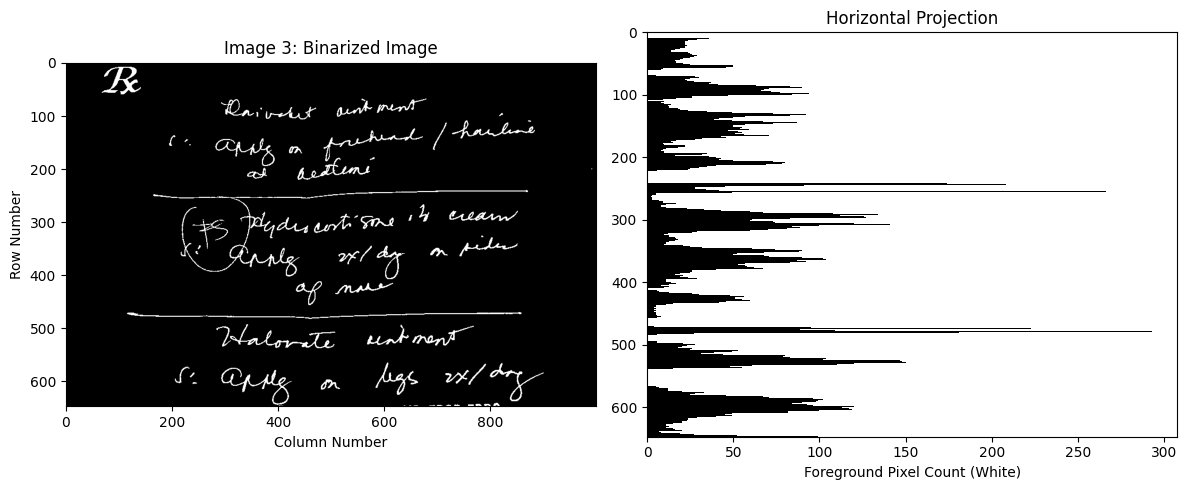

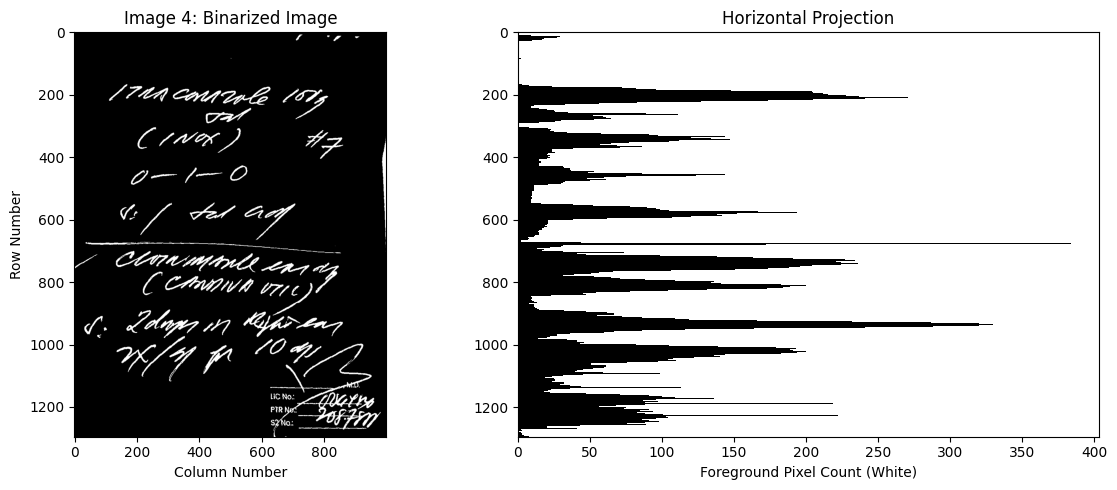

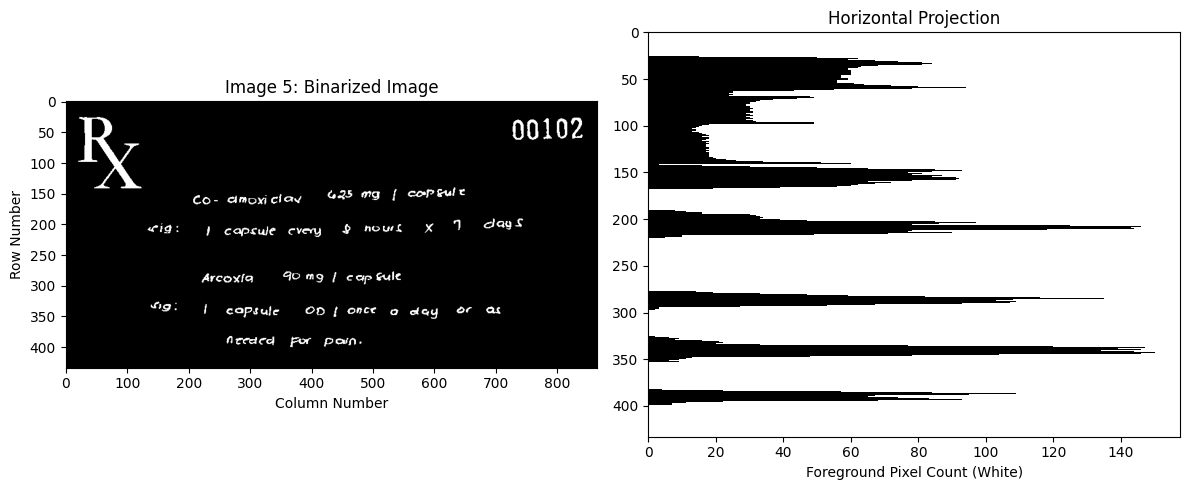

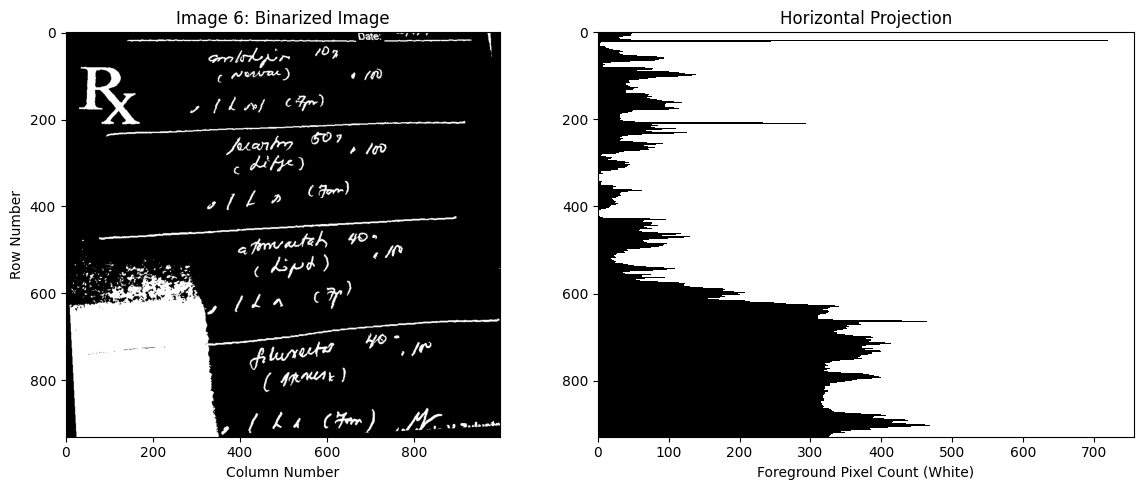

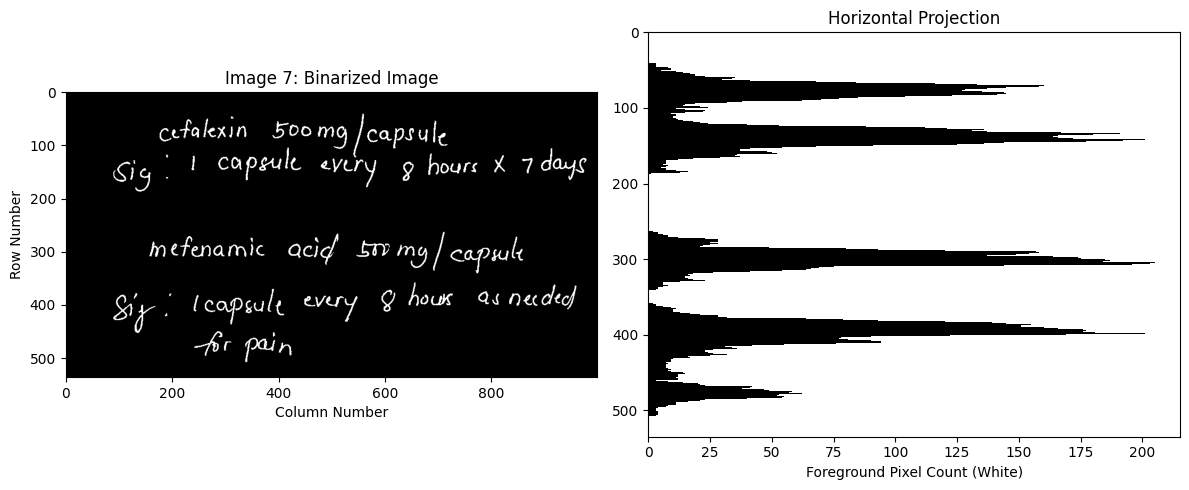

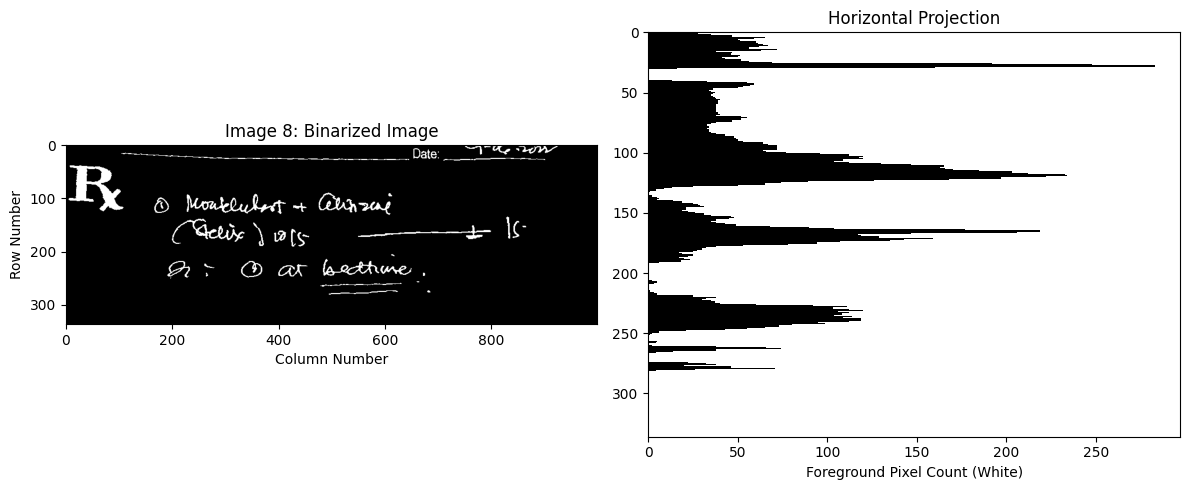

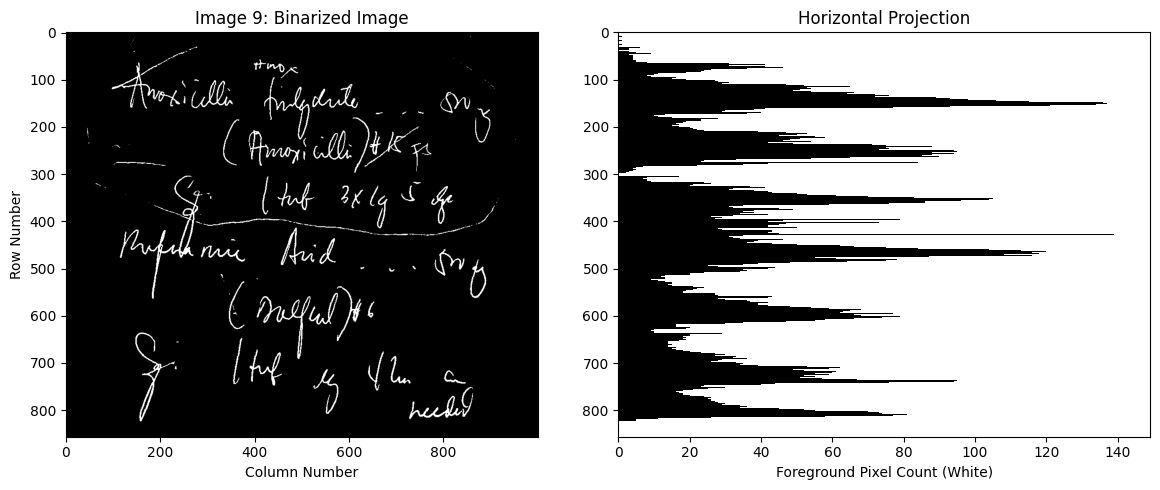

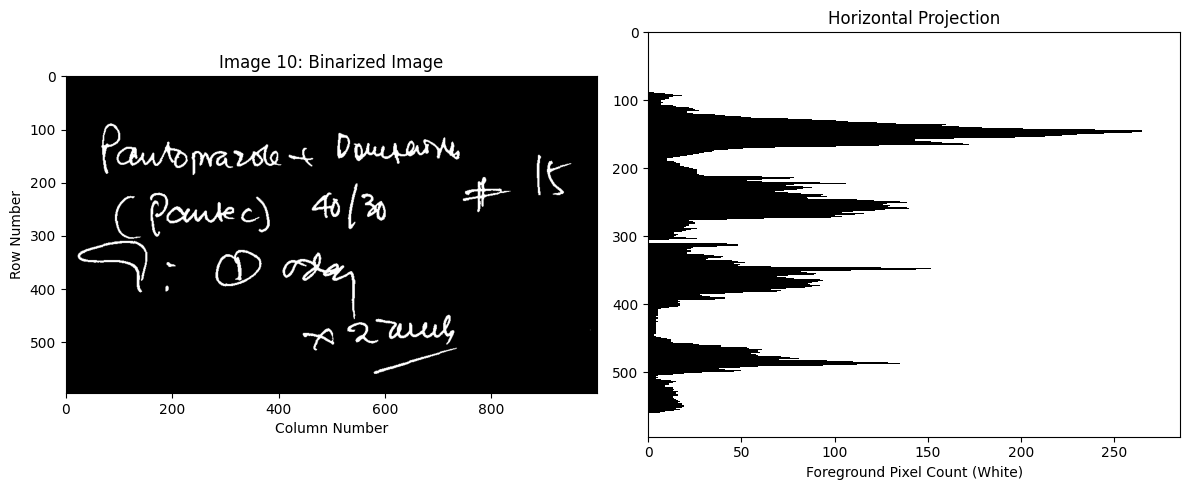

In [82]:
for i, img_pil in enumerate(corrected_imgs):

    img_np = np.array(img_pil.convert('L'))
    height = img_np.shape[0]

    # We count the number of white pixels (value 255) for each row
    # This creates a 1D array of size 'height'
    horizontal_projection = np.sum(img_np == 1, axis=1)

    # We'll create a new figure for each image and its histogram
    plt.figure(figsize=(12, 5))

    # Subplot 1: The Image
    plt.subplot(1, 2, 1) # (1 row, 2 columns, 1st plot)
    plt.imshow(img_np, cmap='gray')
    plt.title(f'Image {i+1}: Binarized Image')
    plt.ylabel('Row Number')
    plt.xlabel('Column Number')

    # Subplot 2: The Histogram
    plt.subplot(1, 2, 2) # (1 row, 2 columns, 2nd plot)

    # Create an array of row numbers [0, 1, 2, ..., height-1]
    row_numbers = np.arange(height)

    # Create a horizontal bar chart
    # y = row numbers, width = pixel counts
    # height=1.0 makes the bars touch, like in your example
    plt.barh(row_numbers, horizontal_projection, color='black', height=1.0)

    # Invert the y-axis so that row 0 is at the top,
    # matching the 'imshow' display.
    plt.gca().invert_yaxis()

    # Set the y-axis limits to be tight with the image
    plt.ylim(height-1, 0) # (max, min) for an inverted axis

    plt.title('Horizontal Projection')
    plt.xlabel('Foreground Pixel Count (White)')

    plt.tight_layout()

## Dilation

In [83]:
dilated_imgs = []

In [84]:
for img in binarized_imgs:
  kernel = np.ones((3,85), np.uint8)
  dilated = cv2.dilate(img, kernel, iterations = 1)
  dilated_imgs.append(dilated)


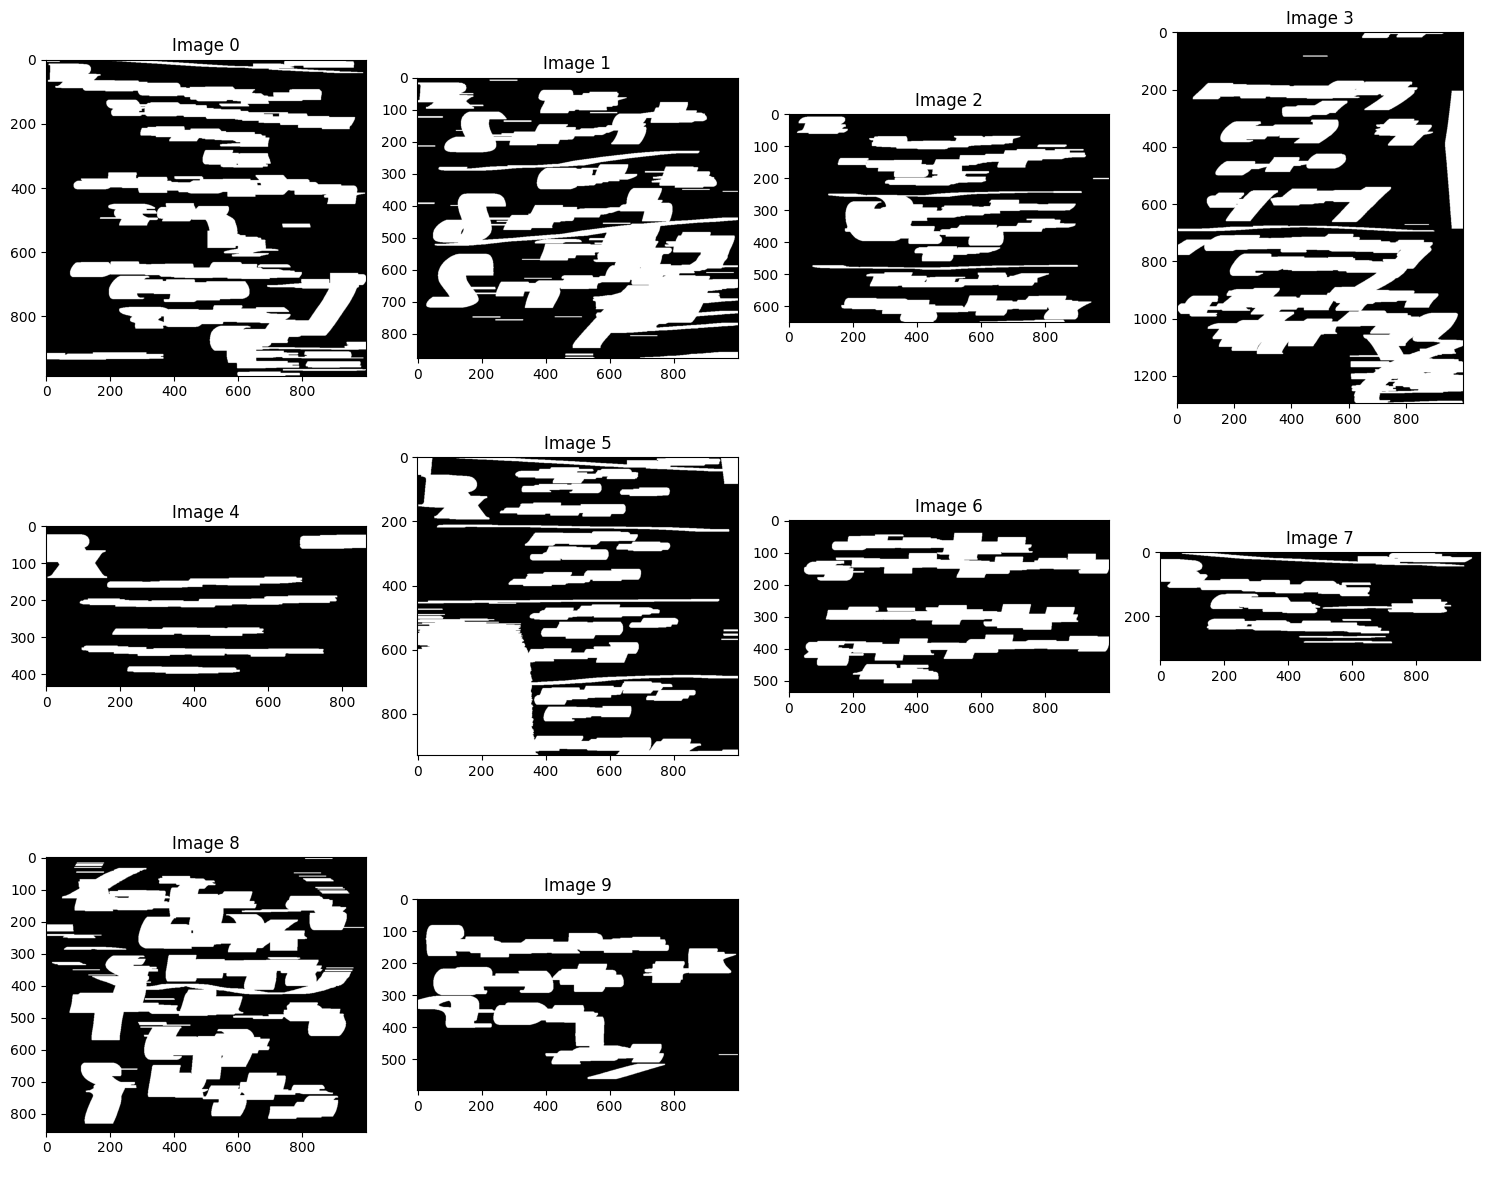

In [85]:
display_plots(dilated_imgs)

## Contours and Bounded Boxes

In [86]:
bounded_imgs = []

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt # Essential for displaying in a notebook

# --- Modified segment_lines_and_trim function to return bounding box coordinates ---

def segment_lines_to_bboxes(deskewed_binarized_img):
    # 1. Horizontal Projection Profile (HPP) - Find Vertical Boundaries
    img_inverted = 255 - deskewed_binarized_img 
    horizontal_projection = np.sum(img_inverted, axis=1)

    text_threshold = 5 
    line_vertical_bounds = []
    is_text_line = False
    start_y = 0

    for y, sum_val in enumerate(horizontal_projection):
        if sum_val > text_threshold and not is_text_line:
            is_text_line = True
            start_y = y
        
        elif sum_val <= text_threshold and is_text_line:
            is_text_line = False
            end_y = y
            padding_y = 5 
            line_vertical_bounds.append((max(0, start_y - padding_y), min(deskewed_binarized_img.shape[0], end_y + padding_y)))
            
    if is_text_line:
        padding_y = 5
        line_vertical_bounds.append((max(0, start_y - padding_y), deskewed_binarized_img.shape[0]))


    # 2. Vertical Projection Profile (VPP) - Find Horizontal Boundaries for each line
    final_bboxes = [] # List of (x, y, w, h)

    for y_start, y_end in line_vertical_bounds:
        line_region = deskewed_binarized_img[y_start:y_end, :]

        if line_region.size == 0:
            continue

        vertical_projection = np.sum(255 - line_region, axis=0)
        text_cols = np.where(vertical_projection > 0)[0]
        
        if len(text_cols) > 0:
            x_start_content = text_cols[0]
            x_end_content = text_cols[-1] + 1 
            
            # Add horizontal padding
            padding_x = 5
            x_start = max(0, x_start_content - padding_x)
            x_end = min(deskewed_binarized_img.shape[1], x_end_content + padding_x)

            # Final bounding box coordinates (relative to the full image)
            x, y = x_start, y_start
            w = x_end - x_start
            h = y_end - y_start
            
            final_bboxes.append((x, y, w, h))

    return final_bboxes


# --- Revised Integration for Display in Notebook ---

# Assume 'deskewed_binarized_imgs' is your list of input images.
# For simplicity in this display example, we'll only process the first image.
if not deskewed_binarized_imgs:
    print("Error: The input list 'deskewed_binarized_imgs' is empty.")
else:
    # Select the first image for demonstration
    deskewed_img = deskewed_binarized_imgs[0] 
    
    # Get the bounding boxes for the lines
    line_bboxes = segment_lines_to_bboxes(deskewed_img)

    # Convert the single-channel (binarized) image to a 3-channel image 
    # so we can draw colored boxes on it.
    img_with_lines = cv2.cvtColor(deskewed_img.copy(), cv2.COLOR_GRAY2BGR)

    # Draw the bounding boxes
    for x, y, w, h in line_bboxes:
        # Use a contrasting color (e.g., blue, BGR format)
        cv2.rectangle(img_with_lines, (x, y), (x + w, y + h), (255, 0, 0), 2) # Blue box, thickness 2

    # Display the image using Matplotlib (standard for Jupyter/Colab notebooks)
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for correct display
    plt.title(f"Segmented Lines: {len(line_bboxes)} Lines Detected")
    plt.axis('off')
    plt.show()

# The image saving block is completely removed, as requested.

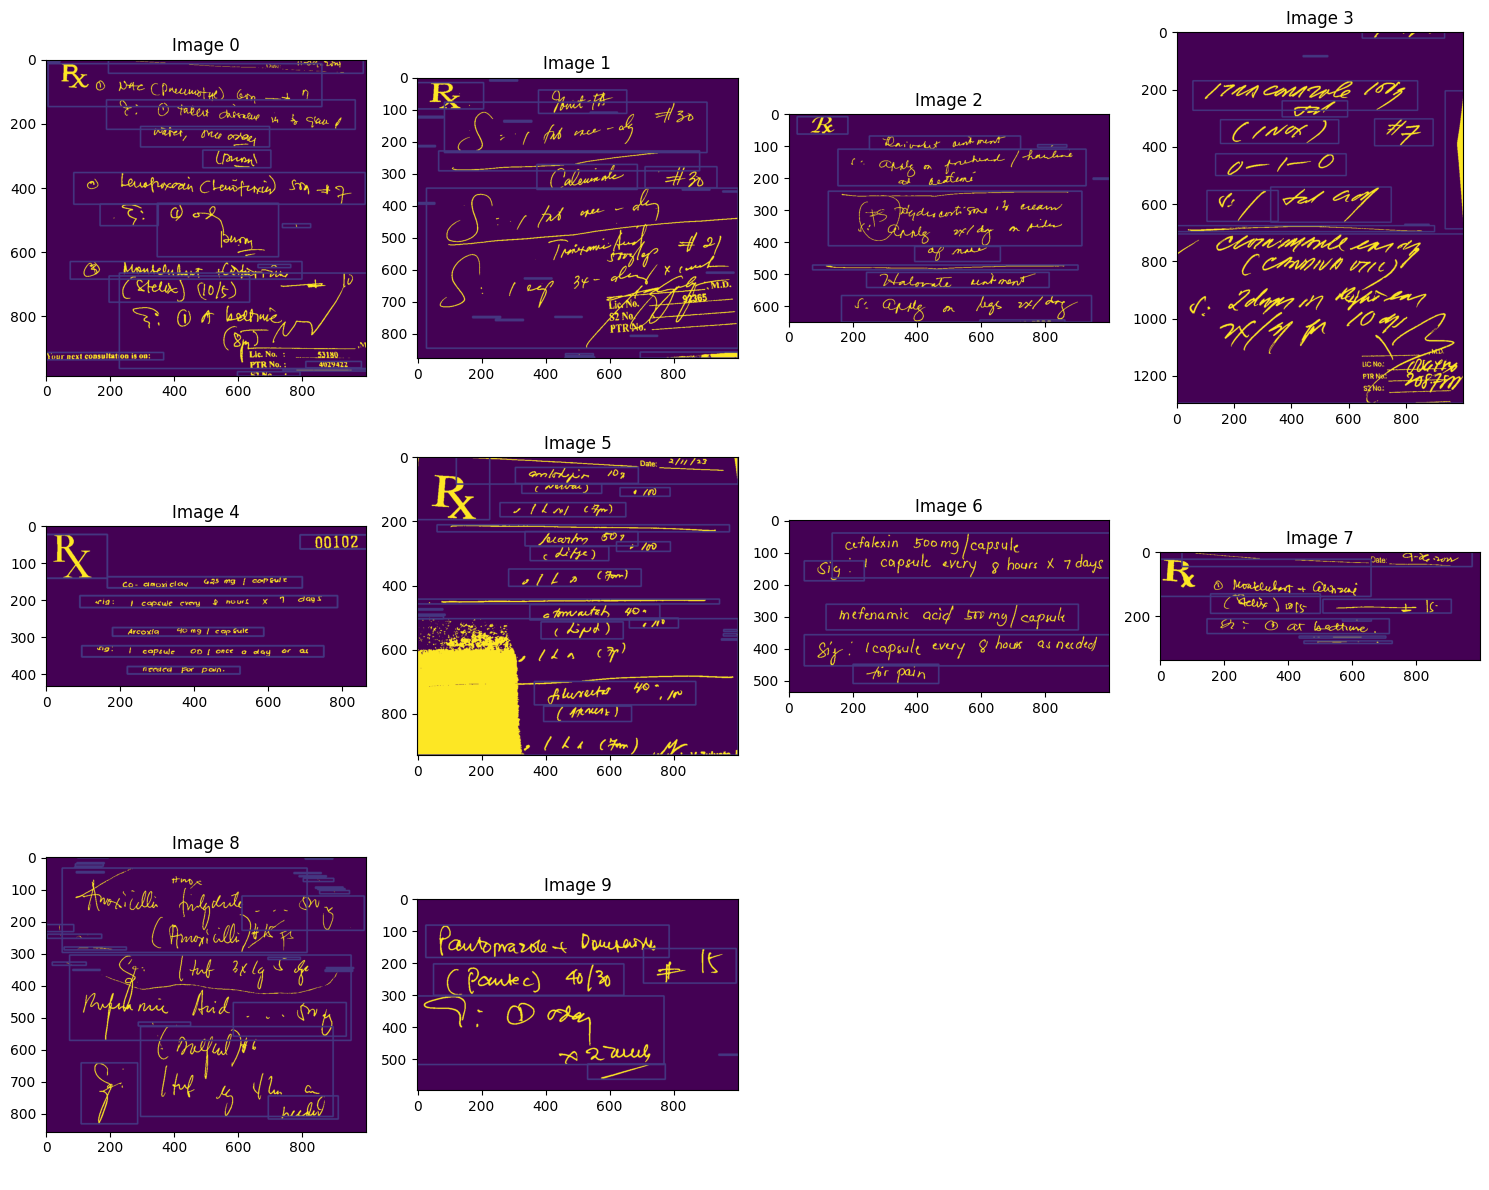

In [88]:
display_plots(bounded_imgs,0)